In [1]:
import os
import sys
%matplotlib inline
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import datetime
import rpy2
import seaborn as sns
import anndata

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, dpi_save=1000)

In [59]:
from platform import python_version

print(python_version())
print(sc.__version__)

3.8.6
1.8.1


# Define Variables

In [ ]:
# Load protein data with raw counts
protein = sc.read('')
# Load RNA data
rna = sc.read('')
#
#
#

#### Load in Protein data

In [2]:
path_to = "../SIGAD11/"
protein_SIGAG5 = sc.read_mtx(path_to +'matrix.mtx.gz').T
protein_SIGAG5_features = pd.read_csv(path_to + 'features.tsv.gz', sep ="-", header=None)
protein_SIGAG5_barcodes = pd.read_csv(path_to + 'barcodes.tsv.gz', header=None)

protein_SIGAG5.var_names = protein_SIGAG5_features[0]
protein_SIGAG5.obs_names = protein_SIGAG5_barcodes[0]
path_to = "../SIGAD11/"
protein_SIGAG5 = sc.read_mtx(path_to +'matrix.mtx.gz').T
protein_SIGAG5_features = pd.read_csv(path_to + 'features.tsv.gz', sep ="-", header=None)
protein_SIGAG5_barcodes = pd.read_csv(path_to + 'barcodes.tsv.gz', header=None)

protein_SIGAG5.var_names = protein_SIGAG5_features[0]
protein_SIGAG5.obs_names = protein_SIGAG5_barcodes[0]
path_to = "../SIGAE11/"
protein_SIGAH5 = sc.read_mtx(path_to +'matrix.mtx.gz').T
protein_SIGAH5_features = pd.read_csv(path_to + 'features.tsv.gz', sep ="-", header=None)
protein_SIGAH5_barcodes = pd.read_csv(path_to + 'barcodes.tsv.gz', header=None)

protein_SIGAH5.var_names = protein_SIGAH5_features[0]
protein_SIGAH5.obs_names = protein_SIGAH5_barcodes[0]
protein = protein_SIGAG5.concatenate(protein_SIGAH5, batch_key='Identifier',batch_categories=['SIGAD11','SIGAE11'],index_unique='-')
protein = protein_SIGAG5.concatenate(protein_SIGAH5, batch_key='Identifier',batch_categories=['SIGAD11','SIGAE11'],index_unique='-')

#### Load in rna data

In [3]:
# #rna = sc.read('../CD34_processed_object_level1_anno_07072021.h5ad')
# rna = sc.read('/nfs/team205/ig7/resources/scripts_dont_modify/cite_seq/Cite_Seq_RNA_simple_raw_27102021.h5ad')
# rna

In [4]:
# rna.obs['new_index'] = rna.obs.index.str.replace('-1-SIGAG5-SIGAG5','-SIGAD11',regex=True)
# rna.obs['new_index'] = rna.obs['new_index'].str.replace('-1-SIGAH5-SIGAH5','-SIGAE11',regex=True)
# rna.obs.index = rna.obs['new_index']
# del rna.obs['new_index']
# rna.obs.index.name = ''

# Check RNA protein intersection length

In [5]:
list1 = list(rna.obs.index)
list2 = list(protein.obs.index)
list3 = list(set(list1) & set(list2))
len(list3)

NameError: name 'rna' is not defined

# Subset Protein to RNA matched

In [6]:
protein = protein[protein.obs.index.isin(rna.obs.index)]
protein

NameError: name 'rna' is not defined

# Copy over meta data from RNA

In [7]:
# Also add columns to batch correct!
protein.obs[list(rna.obs.columns)] = rna.obs[list(rna.obs.columns)][rna.obs.index.isin(protein.obs.index)]

NameError: name 'rna' is not defined

In [8]:
adata = protein[:]

In [9]:
new_ab=[]
for ab in adata.var_names:
    if ab !="unmapped":
        new_ab.append(ab)
        
adata=adata[:,pd.Index(new_ab)].copy()
print("adata shape: "+str(adata.shape))

adata shape: (40962, 198)


In [10]:
adata_initial = adata.copy()

# QC protein data

normalizing counts per cell
    finished (0:00:00)


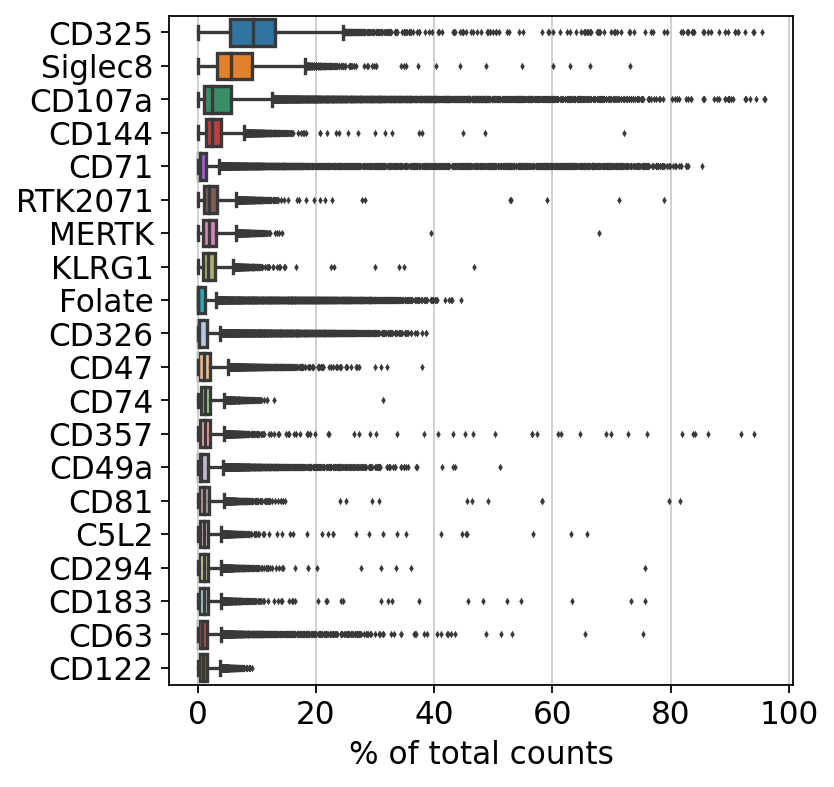

In [11]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [12]:
sc.pp.filter_cells(adata, min_genes=30) #they are not genes, but AB. The code is the same

filtered out 355 cells that have less than 30 genes expressed


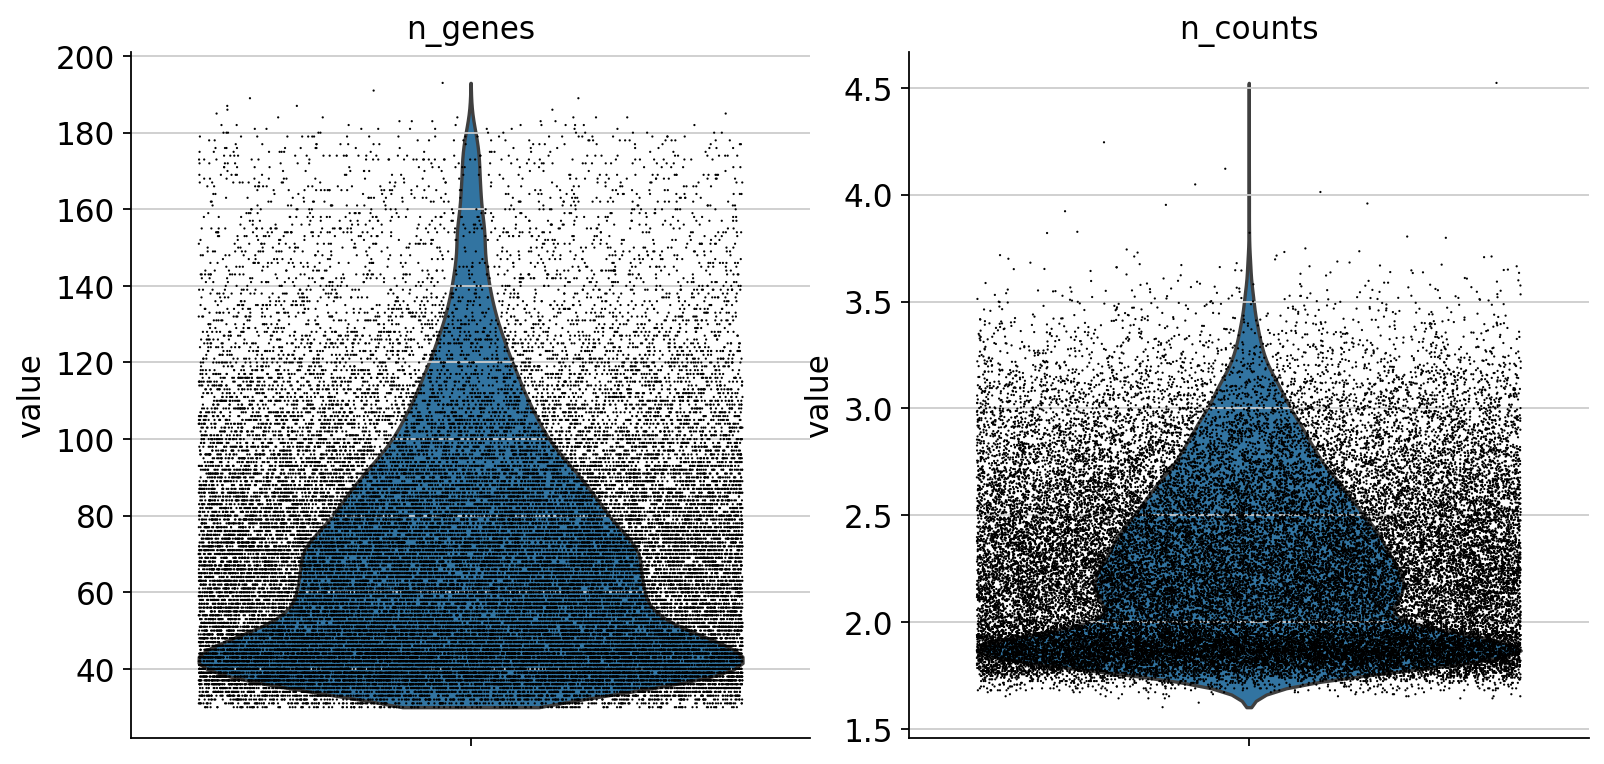

In [13]:
adata.obs['n_counts'] = np.log10(adata.X.sum(axis=1).A1) #they are not genes, but AB. The code is the same
sc.pl.violin(adata, ['n_genes', 'n_counts'],
             jitter=0.4, multi_panel=True)

In [14]:
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

In [15]:
print(np.mean(adata.obs['n_counts']))
print(np.mean(adata.obs['n_genes']))

307.1097
70.16790208584727


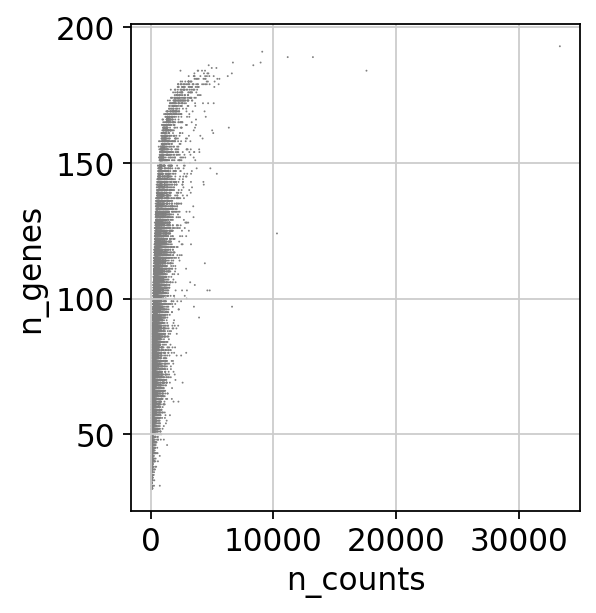

In [16]:
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [17]:
sc.pp.filter_genes(adata, min_cells=3)

In [18]:
# if need to be stricter could use 4000
adata = adata[adata.obs["n_counts"] < 5000, :]

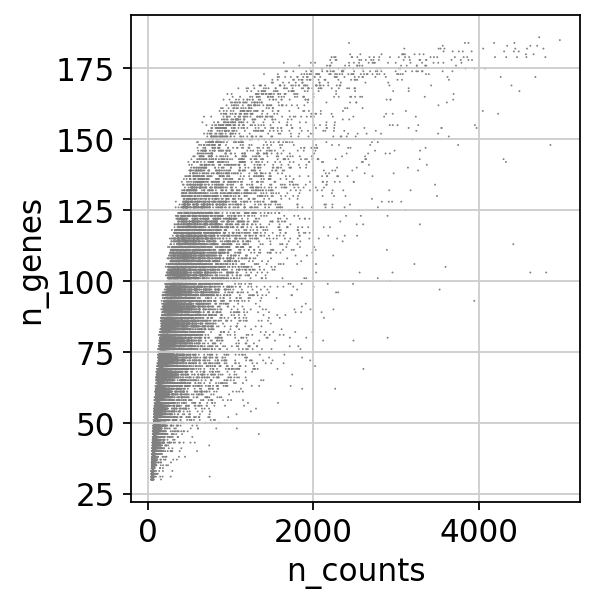

In [19]:
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [20]:
adata_qc=adata.copy()

In [21]:
#adata_qc.write(#"20210713_mq224_9F_postQC_CD34_ADT_YS-FL-FBM-CB.h5ad")

In [22]:
import numpy as np
from sklearn.mixture import GaussianMixture
import anndata

cell_protein_matrix = adata_qc.copy()

# DSB Method - clustering and visualisation

# Model assumptions

- Low nUMI counts are a proxy for low quality cells and low quality droplets and have a higher contribution from soup/background thus a background mixed model can be estimated from them.
- Without a distinct peak of low_NUMI cells, this can be difficult to estimate
- In the abscence of a low nUMI quality peak, utilising a 95%CI cutoff of the nUMI, the background signature may not be a good estimate of "background/soup" as the genes significantly contribute to meaningful variance. 

# Read here for automated peak density estimation :: Issac
http://ianmadd.github.io/pages/PeakDensityDistribution.html

In [23]:
cell_protein_matrix = adata_initial[adata_qc.obs_names,:].copy()   

In [24]:
def getNegDroplets(adata, lamda=1.96): 
    import seaborn as sns
    umi = np.log1p(np.sum(adata.X.toarray(), axis=1)) #umis per cell
    mu_umi = np.mean(umi) #mean of umi counts
    sd_umi = (np.std(umi)) #SD of the umi counts  # estimate at 95%CI of binomial disrtr
    print(mu_umi)
    print(sd_umi)
    sub_threshold = mu_umi-(lamda*sd_umi) 
    print(sub_threshold)
    #plt.hist(umi, bins = 100)
    plt.axvline(x=sub_threshold,color='red')
    #Simplified version. They used Seurat function,  but we dont want that.
    #anything less than that would be empty droplets.

    sn = sns.distplot(umi, hist=True, kde=True, 
             bins=100, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
    sn
    return adata[umi<sub_threshold,:].copy()
#empty_drop_matrix = getNegDroplets(adata_initial, lamda=1.96)#
def auto_detect_UMI_Peaks(adata, lamda=1.96):
    from scipy.signal import find_peaks
    from itertools import compress
    def count_dist_peaks(series, bins, prominence, width):
        count, division = np.histogram(series, bins=bins)
        peaks, props = find_peaks(count, prominence=prominence, width=width)
        return peaks , division
    ## Determine cutoff values
    umi = np.log1p(np.sum(adata.X.toarray(), axis=1)) #umis per cell
    mu_umi = np.mean(umi) #mean of umi counts
    sd_umi = (np.std(umi)) #SD of the umi counts  # estimate at 95%CI of binomial disrtr
    #print(mu_umi)
    #print(sd_umi)
    # Use Sturge’s Rule to determine Bin count:
    bins = round(1 + (3.322*np.log(len(umi))))
    prominence_iter = list(range(1,20))
    #Find a left peak which is smaller then (MED-1.48*MAD)
    # 1.48 * MAD https://s3.amazonaws.com/media2.fairhealth.org/resource/asset/FH%20Methodology%20-%20Median%20Absolute%20Deviation.pdf
    MAD = np.median(np.absolute(umi - np.median(umi))) * 1.48
    MED = np.median(umi)
    #sub_threshold = mu_umi-(MAD) 
    sub_threshold = mu_umi-(lamda*sd_umi) 
    print('Val at Lambda = ' + str(sub_threshold))
    val_list = []
    arr_list = []
    for i in prominence_iter:
        arr , val = count_dist_peaks(umi , bins=bins, prominence=i,width=[0,10])
        #peak_dic = {col:count_dist_peaks(train_df[col].values, bins=100, prominence=700,width=[0,10]) for col in var_names}
        #non_empty_peaks = {k:v for k,v in peak_dic.items() if len(v) > 0}
    # Check for a peak which mtaches rule for smaller than 1.4826 MAD
        arr_list.append(list(arr))
        val_list.append(list(val))
    indexes = list(range(0,len(arr_list)-1))
    arr_out = []
    val_out = []
    for x in indexes:
        inx = np.array(val_list[x])[arr_list[x]] < sub_threshold
        small_peaks = list(compress(val_list[x], inx))
        if (len(small_peaks)) >= 1 :
            arr_out = arr_list[x]
            val_out = val_list[x]
            print('Sucess for index' + ' '+ str(x))
        else:
            print('skipping index' + ' '+ str(x))
    #plt.hist(umi, bins = 100)
    plt.axvline(x=sub_threshold,color='red')
        #Simplified version. They used Seurat function,  but we dont want that.
        #anything less than that would be empty droplets.
    #plt.axvline(x=max(np.array(val_out)[arr_out]),color='green')
    sn = sns.distplot(umi, hist=True, kde=True, rug=True, 
                 bins=bins, color = 'darkblue', 
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 4})
    if len(arr_out) < 1 :
        print('no peaks were detected at value < lambda, defaulting to using 95%CI')
        return adata[umi<sub_threshold,:].copy()
    else:
        plt.axvline(x=(np.array(val_out)[arr_out][0]),color='blue')
        print('Optimal peak X val = ' + str((np.array(val_out)[arr_out][0])))
        return adata[umi<(np.array(val_out)[arr_out][0]),:].copy()
        
    
    #x = np.log1p(np.sum(adata.X.toarray(), axis=1))
    #from sklearn.neighbors import KernelDensity
    ## instantiate and fit the KDE model
    #kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
    #kde.fit(x[:, None])
    ## score_samples returns the log of the probability density
    #logprob = kde.score_samples(x[:, None])
    return adata[umi<(np.array(val_out)[arr_out][0]),:].copy()

# GMM as Density Estimation for soup/background removal
Though GMM is often categorized as a clustering algorithm, fundamentally it is an algorithm for density estimation. That is to say, the result of a GMM fit to some data is technically not a clustering model, but a generative probabilistic model describing the distribution of the data.

- automated optimisation of GMM kvalue with max BIC and AIC, only records lowest mean score as background classification

In [25]:
#renormalisation of the counts by empty droplets background.
#cell_protein_matrix and empty_drop_matrix are split from the same matrix,
#only difference is cells, but Ab is the same.
#cell_protein_matrix: adata object.
def DSB(cell_protein_matrix, empty_drop_matrix, pseudocount=10 , use_gmm = False): # If see obvious bimodal peaks, run GMM as this will correct for second peak better
    adt = cell_protein_matrix.X.toarray() #meaningful cells xantibodies
    adtu = empty_drop_matrix.X.toarray() #the non meaninful - empty droplets 
    adt_log = np.log(adt+pseudocount) 
    adtu_log = np.log(adtu+pseudocount)
    mu_u = np.mean(adtu_log, axis=0) #for each protein in empty drop.
    sd_u = np.std(adtu_log, axis=0) #for each protein in empty drop.
    norm_adt = (adt_log-mu_u)/sd_u  #Y=log(Xi+P)-mu / sd
    adata_new = anndata.AnnData(X=norm_adt, obs=cell_protein_matrix.obs, var=cell_protein_matrix.var)
    #new normalised values
    print(adata_new.shape)
    
    if use_gmm == True: #Use GMM when obvious bimodal peaks in expression are present and background soup effect is still aparent after DSB normnalisation
        print("option to use GMM regression detected, proceeding to calculate per gene background")
        # this is to make a background mean to be used for regression later - essentially empty droplets 
        cellwise_background_mean = np.array([]) #equation 2 from this line.
        for column in norm_adt.T:
        #for column in adt.T:
        #for column in adtu_log.T:
            N = np.arange(2, 10)
            models = [None for i in range(len(N))]
            for i in range(len(N)):
                models[i] = GaussianMixture(N[i]).fit(column.reshape(-1,1))
            # compute the AIC and the BIC
            AIC = [m.aic(column.reshape(-1,1)) for m in models]
            BIC = [m.bic(column.reshape(-1,1)) for m in models]
            # get highest AIC/BIC model
            info = [(a + b)/2 for a, b in zip(AIC, BIC)]
            indx = info.index(max(info))
            gmm_fitted = models[indx]
            min_bg = min(gmm_fitted.means_)
            #max_bg = max(gmm_fitted.means_)
            # Here we assume any residual background is the k protein usage of smallest mean value (this includes if the background usage is 0 for circumstances where a protein (i.e housekeeping) is expressed on all cells at a very similar level.)
            cellwise_background_mean = np.append(cellwise_background_mean,  min_bg)### Take min estimate of cluster mean to be classifcation of soup class
        print(len(cellwise_background_mean))
        adata_new.var['bg_mean'] = cellwise_background_mean
        adata_gmm = adata_new[:]
        adata_gmm.X = (adata_gmm.X - cellwise_background_mean)
        adata_new.obs['gmm_score'] = adata_gmm.X.sum(axis=1)
        adata_new.obs['total_counts'] = adata_new.X.sum(axis=1)
        adata_new.obs['gmm_score'] = adata_new.obs['total_counts'] - adata_new.obs['gmm_score'] # gives us a background score per cell
        print("GMM background regression using continous score")
        sc.pp.regress_out(adata_new, keys=['gmm_score'])
        adata_new = adata_new[~adata_new.obs.index.isin(empty_drop_matrix.obs.index)]
        return adata_new
    else:
        print('Regressing effect of categorical : empty drops')
        # sc.pp.regress empty drops
        adata_new.obs['empty_drops'] = 'False'
        adata_new.obs.loc[adata_new.obs.index.isin(empty_drop_matrix.obs.index),'empty_drops'] = 'True'
        sc.pp.regress_out(adata_new, keys=['empty_drops']) 
        adata_new = adata_new[~adata_new.obs.index.isin(empty_drop_matrix.obs.index)]
        return adata_new

# Apply UMI peak detection and GMM density estimation on entire data at once
- Here we make certain assumptions

Val at Lambda = 4.314690589904785
Sucess for index 0
Sucess for index 1
Sucess for index 2
Sucess for index 3
Sucess for index 4
Sucess for index 5
Sucess for index 6
Sucess for index 7
Sucess for index 8
Sucess for index 9
Sucess for index 10
Sucess for index 11
Sucess for index 12
Sucess for index 13
Sucess for index 14
Sucess for index 15
Sucess for index 16
Sucess for index 17


/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


Optimal peak X val = 4.2469516


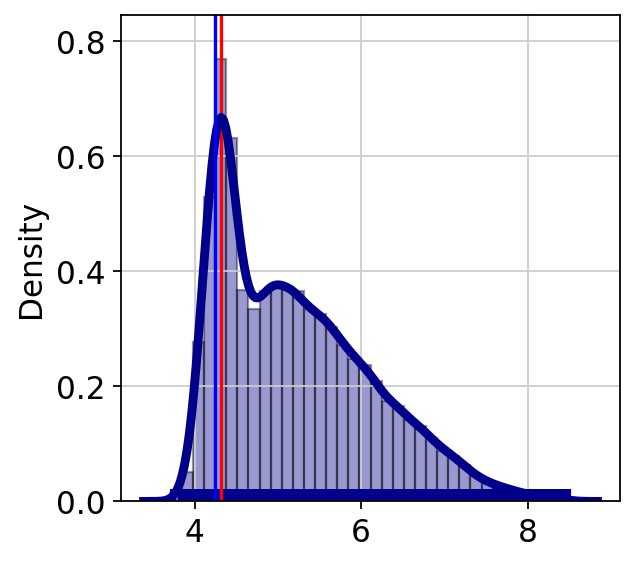

In [31]:
# Detect peaks that are significant and lower/equal to lambda
empty_drop_matrix = auto_detect_UMI_Peaks(adata, lamda=1)

In [32]:
adata_new = DSB(cell_protein_matrix, empty_drop_matrix, pseudocount = 10, use_gmm=True)

(40583, 198)
option to use GMM regression detected, proceeding to calculate per gene background


KeyboardInterrupt: 

In [36]:
pseudocount = 10
use_gmm = True
adt = cell_protein_matrix.X.toarray() #meaningful cells xantibodies
adtu = empty_drop_matrix.X.toarray() #the non meaninful - empty droplets 
adt_log = np.log(adt+pseudocount) 
adtu_log = np.log(adtu+pseudocount)
mu_u = np.mean(adtu_log, axis=0) #for each protein in empty drop.
sd_u = np.std(adtu_log, axis=0) #for each protein in empty drop.
norm_adt = (adt_log-mu_u)/sd_u  #Y=log(Xi+P)-mu / sd
adata_new = anndata.AnnData(X=norm_adt, obs=cell_protein_matrix.obs, var=cell_protein_matrix.var)
#new normalised values
print(adata_new.shape)

if use_gmm == True: #Use GMM when obvious bimodal peaks in expression are present and background soup effect is still aparent after DSB normnalisation
    print("option to use GMM regression detected, proceeding to calculate per gene background")
    # this is to make a background mean to be used for regression later - essentially empty droplets 
    cellwise_background_mean = np.array([]) #equation 2 from this line.
    for column in norm_adt.T:
    #for column in adt.T:
    #for column in adtu_log.T:
        N = np.arange(2, 10)
        models = [None for i in range(len(N))]
        for i in range(len(N)):
            models[i] = GaussianMixture(N[i]).fit(column.reshape(-1,1))
        # compute the AIC and the BIC
        AIC = [m.aic(column.reshape(-1,1)) for m in models]
        BIC = [m.bic(column.reshape(-1,1)) for m in models]
        # get highest AIC/BIC model
        info = [(a + b)/2 for a, b in zip(AIC, BIC)]
        indx = info.index(max(info))
        gmm_fitted = models[indx]
        min_bg = min(gmm_fitted.means_)
        #max_bg = max(gmm_fitted.means_)
        # Here we assume any residual background is the k protein usage of smallest mean value (this includes if the background usage is 0 for circumstances where a protein (i.e housekeeping) is expressed on all cells at a very similar level.)
        cellwise_background_mean = np.append(cellwise_background_mean,  min_bg)### Take min estimate of cluster mean to be classifcation of soup class
    print(len(cellwise_background_mean))
    adata_new.var['bg_mean'] = cellwise_background_mean
    adata_gmm = adata_new[:]
    adata_gmm.X = (adata_gmm.X - cellwise_background_mean)
    adata_new.obs['gmm_score'] = adata_gmm.X.sum(axis=1)
    adata_new.obs['total_counts'] = adata_new.X.sum(axis=1)
    adata_new.obs['gmm_score'] = adata_new.obs['total_counts'] - adata_new.obs['gmm_score'] # gives us a background score per cell
    print("GMM background regression using continous score")
    sc.pp.regress_out(adata_new, keys=['gmm_score'])
    adata_new = adata_new[~adata_new.obs.index.isin(empty_drop_matrix.obs.index)]

else:
    print('Regressing effect of categorical : empty drops')
    # sc.pp.regress empty drops
    adata_new.obs['empty_drops'] = 'False'
    adata_new.obs.loc[adata_new.obs.index.isin(empty_drop_matrix.obs.index),'empty_drops'] = 'True'
    sc.pp.regress_out(adata_new, keys=['empty_drops']) 
    adata_new = adata_new[~adata_new.obs.index.isin(empty_drop_matrix.obs.index)]


(40583, 198)
option to use GMM regression detected, proceeding to calculate per gene background


KeyboardInterrupt: 

In [56]:
m = GaussianMixture(N[i]).fit(column.reshape(-1,1))

In [57]:
help(m)

Help on GaussianMixture in module sklearn.mixture._gaussian_mixture object:

class GaussianMixture(sklearn.mixture._base.BaseMixture)
 |  GaussianMixture(n_components=1, *, covariance_type='full', tol=0.001, reg_covar=1e-06, max_iter=100, n_init=1, init_params='kmeans', weights_init=None, means_init=None, precisions_init=None, random_state=None, warm_start=False, verbose=0, verbose_interval=10)
 |  
 |  Gaussian Mixture.
 |  
 |  Representation of a Gaussian mixture model probability distribution.
 |  This class allows to estimate the parameters of a Gaussian mixture
 |  distribution.
 |  
 |  Read more in the :ref:`User Guide <gmm>`.
 |  
 |  .. versionadded:: 0.18
 |  
 |  Parameters
 |  ----------
 |  n_components : int, default=1
 |      The number of mixture components.
 |  
 |  covariance_type : {'full', 'tied', 'diag', 'spherical'}, default='full'
 |      String describing the type of covariance parameters to use.
 |      Must be one of:
 |  
 |      'full'
 |          each comp

In [44]:
models = models[:-1]

In [45]:
AIC = [m.aic(column.reshape(-1,1)) for m in models]

In [46]:
m = models[1]

In [49]:
m.aic

<bound method GaussianMixture.aic of GaussianMixture(n_components=3)>

In [51]:
get_params(m)

NameError: name 'get_params' is not defined

# Option 2:: Create integrated loop which estimates density peaks, applies GMM and concatenates reults per sample
- underlying assumption that technical effect between batches outweighs the benefit of collectively estimating outliers contributed by tecdhnical effects such as GEM production and 10X microfluidics

In [28]:
cite_seq_sample_identifier = 'Identifier'
cell_protein_matrix_total = adata_initial[adata_qc.obs_names,:].copy()   

In [29]:
#renormalisation of the counts by empty droplets background.
#cell_protein_matrix and empty_drop_matrix are split from the same matrix,
#only difference is cells, but Ab is the same.
#cell_protein_matrix: adata object.
def DSB_per_sample(cell_protein_matrix, empty_drop_matrix, pseudocount=10 , use_gmm = False): # If see obvious bimodal peaks, run GMM as this will correct for second peak better
    adt = cell_protein_matrix.X.toarray() #meaningful cells xantibodies
    adtu = empty_drop_matrix.X.toarray() #the non meaninful - empty droplets 
    adt_log = np.log(adt+pseudocount) 
    adtu_log = np.log(adtu+pseudocount)
    mu_u = np.mean(adtu_log, axis=0) #for each protein in empty drop.
    sd_u = np.std(adtu_log, axis=0) #for each protein in empty drop.
    norm_adt = (adt_log-mu_u)/sd_u  #Y=log(Xi+P)-mu / sd
    adata_new = anndata.AnnData(X=norm_adt, obs=cell_protein_matrix.obs, var=cell_protein_matrix.var)
    print(adata_new.shape)
    
    if use_gmm == True: #Use GMM when obvious bimodal peaks in expression are present and background soup effect is still aparent after DSB normnalisation
        print("option to use GMM regression detected, proceeding to calculate per gene background")
        # this is to make a background mean to be used for regression later - essentially empty droplets 
        cellwise_background_mean = np.array([]) #equation 2 from this line.
        for column in norm_adt.T:
        #for column in adt.T:
        #for column in adtu_log.T:
            N = np.arange(2, 10)
            models = [None for i in range(len(N))]
            for i in range(len(N)):
                models[i] = GaussianMixture(N[i]).fit(column.reshape(-1,1))
            # compute the AIC and the BIC
            AIC = [m.aic(column.reshape(-1,1)) for m in models]
            BIC = [m.bic(column.reshape(-1,1)) for m in models]
            # get highest AIC/BIC model
            info = [(a + b)/2 for a, b in zip(AIC, BIC)]
            indx = info.index(max(info))
            gmm_fitted = models[indx]
            min_bg = min(gmm_fitted.means_)
            #max_bg = max(gmm_fitted.means_)
            # Here we assume any residual background is the k protein usage of smallest mean value (this includes if the background usage is 0 for circumstances where a protein (i.e housekeeping) is expressed on all cells at a very similar level.)
            cellwise_background_mean = np.append(cellwise_background_mean,  min_bg)### Take min estimate of cluster mean to be classifcation of soup class
        print(len(cellwise_background_mean))
        adata_new.var['bg_mean'] = cellwise_background_mean
        adata_gmm = adata_new[:]
        adata_gmm.X = (adata_gmm.X - cellwise_background_mean)
        adata_new.obs['gmm_score'] = adata_gmm.X.sum(axis=1)
        adata_new.obs['total_counts'] = adata_new.X.sum(axis=1)
        adata_new.obs['gmm_score'] = adata_new.obs['total_counts'] - adata_new.obs['gmm_score'] # gives us a background score per cell
        print("GMM background regression using continous score")
        sc.pp.regress_out(adata_new, keys=['gmm_score'])
        adata_new = adata_new[~adata_new.obs.index.isin(empty_drop_matrix.obs.index)]
        return adata_new
    else:
        print('Regressing effect of categorical : empty drops')
        # sc.pp.regress empty drops
        adata_new.obs['empty_drops'] = 'False'
        adata_new.obs.loc[adata_new.obs.index.isin(empty_drop_matrix.obs.index),'empty_drops'] = 'True'
        sc.pp.regress_out(adata_new, keys=['empty_drops']) 
        adata_new = adata_new[~adata_new.obs.index.isin(empty_drop_matrix.obs.index)]
        return adata_new
    
def apply_DSB_per_sample(cell_protein_matrix, empty_drop_matrix, pseudocount = 10, use_gmm=True):
    data_dic = {}
    for i in adata.obs[cite_seq_sample_identifier].unique():
        print('Processing sample ' + i)
        cell_protein_matrix = cell_protein_matrix_total[cell_protein_matrix_total.obs[cite_seq_sample_identifier].isin([i])]   
        adata_temp = adata[adata.obs[cite_seq_sample_identifier].isin([i])]
        empty_drop_matrix = auto_detect_UMI_Peaks(adata_temp, lamda=1.96)
        adata_new =  DSB_per_sample(cell_protein_matrix, empty_drop_matrix, pseudocount = pseudocount, use_gmm=use_gmm)
        #normalised values
        sc.pp.scale(adata_new, zero_center=True, max_value=None, copy=False, layer=None, obsm=None)
        globals()['dat_'+str(i)] = adata_new
        data_dic['dat_'+str(i)] =  globals()['dat_'+str(i)]
    data_list = list(data_dic.values())
    adata_per_sample = data_list[0].concatenate(data_list[1:], join='inner',index_unique=None, batch_categories=None)
    return adata_per_sample

Processing sample SIGAD11
Val at Lambda = 3.588350422382355
skipping index 0
skipping index 1
skipping index 2
skipping index 3
skipping index 4
skipping index 5
skipping index 6
skipping index 7
skipping index 8
skipping index 9
skipping index 10
skipping index 11
skipping index 12
skipping index 13
skipping index 14
skipping index 15
skipping index 16
skipping index 17


/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


no peaks were detected at value < lambda, defaulting to using 95%CI
(15905, 198)
option to use GMM regression detected, proceeding to calculate per gene background


/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/numpy/core/_methods.py:250: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

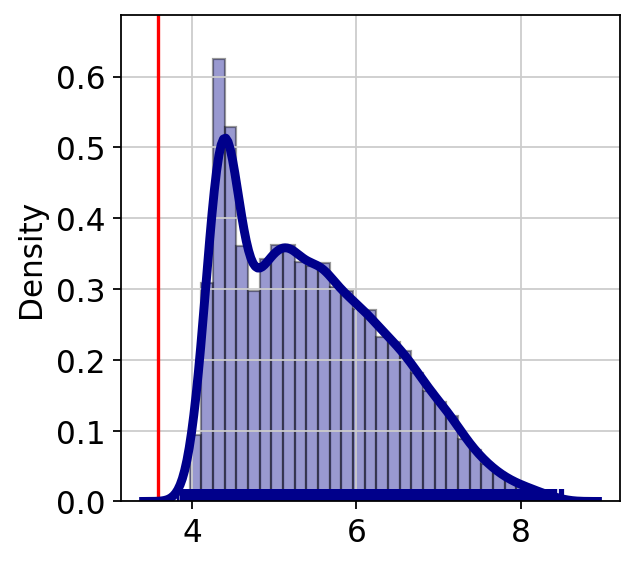

In [30]:
adata_per_sample = apply_DSB_per_sample(cell_protein_matrix, empty_drop_matrix, pseudocount = 10, use_gmm=True)
adata_new = adata_per_sample

# You are done! Rest of this is just sanity checks

# Sanity check plots

In [288]:
gene_list1 = [
'CD34',
'CD7',
'CD127',
'LT_bR',
'CD301',
'CD1c',
'HLA_DR',
'CD16',
'CD4',
'CD14',
'CD117',
'CD41',
'CD61',
'CLEC1B',
'CD235a',
'CD31',
'CD201',
'CD309',
'CD90',
'CD49a',
'CD146',
'CD326'
]

adata_new.obs["final_anno_broad"] = adata.obs["final_anno_broad"].cat.reorder_categories([
'Progenitors',
'Lymphoid',
'pDC precursor',
'Monocyte',
'Macrophage',
'Mast_cell',
'MK',
'Erythroid',
'Endothelium',
'Fibroblast',
'Smooth_Muscle',
'Endoderm'
])

In [289]:
adata.obs["final_anno_broad"] = adata.obs["final_anno_broad"].cat.reorder_categories([
'Progenitors',
'Lymphoid',
'pDC precursor',
'Monocyte',
'Macrophage',
'Mast_cell',
'MK',
'Erythroid',
'Endothelium',
'Fibroblast',
'Smooth_Muscle',
'Endoderm'
])

# Just using raw values, no normalisation :: do not re-run

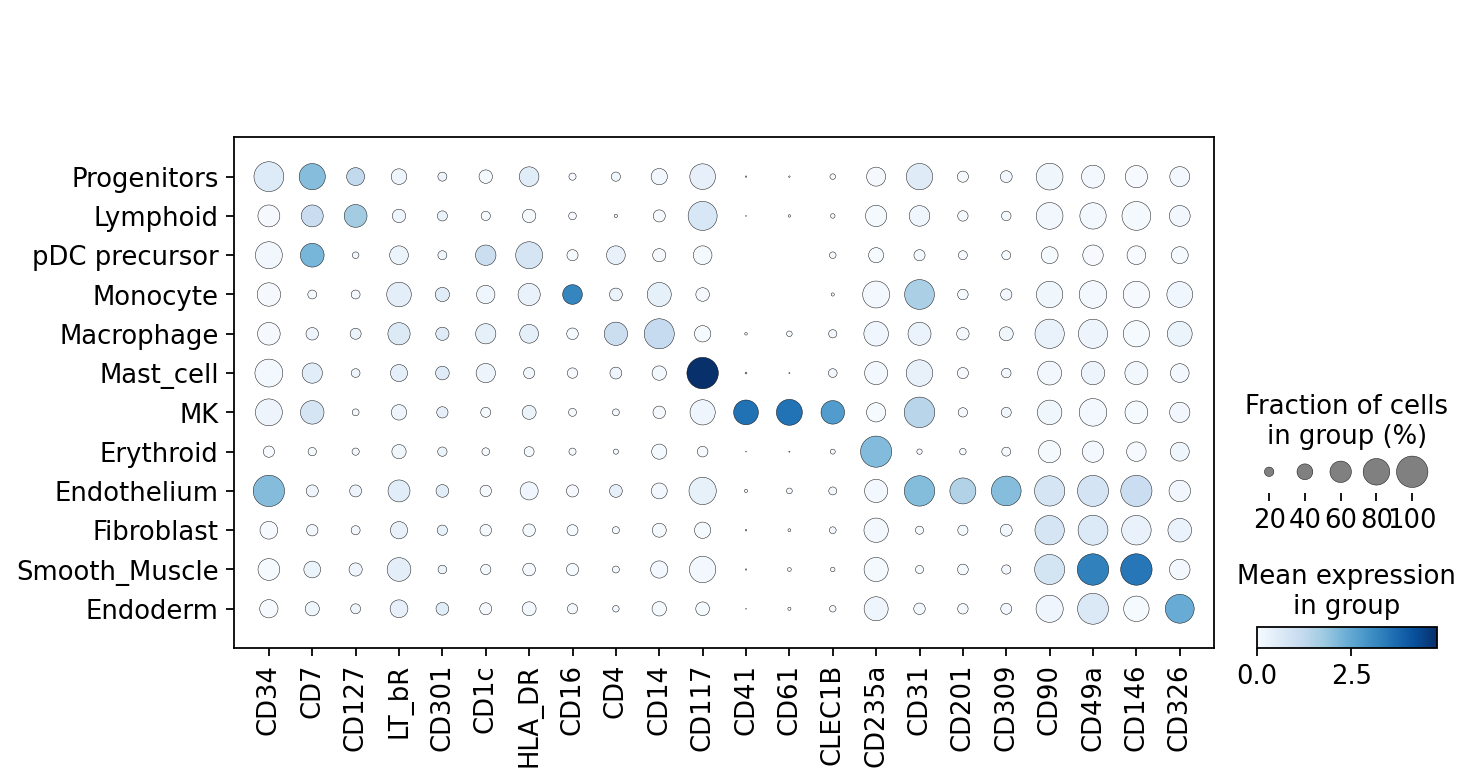

In [264]:
# Just using raw values, no normalisation 
sc.pp.scale(adata, zero_center=False, max_value=None, copy=False)
sc.pl.dotplot(adata, var_names=gene_list1, groupby='final_anno_broad', use_raw=False, cmap='Blues')

# Plot ran with DSB and GMM per sample
- Warning! Since the datasets are normalised and scaled independently, this assumes that each batch has a similar variance structure! 
- This shows some improvement over raw

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Identifier' as categorical
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'identifier' as categorical
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated 

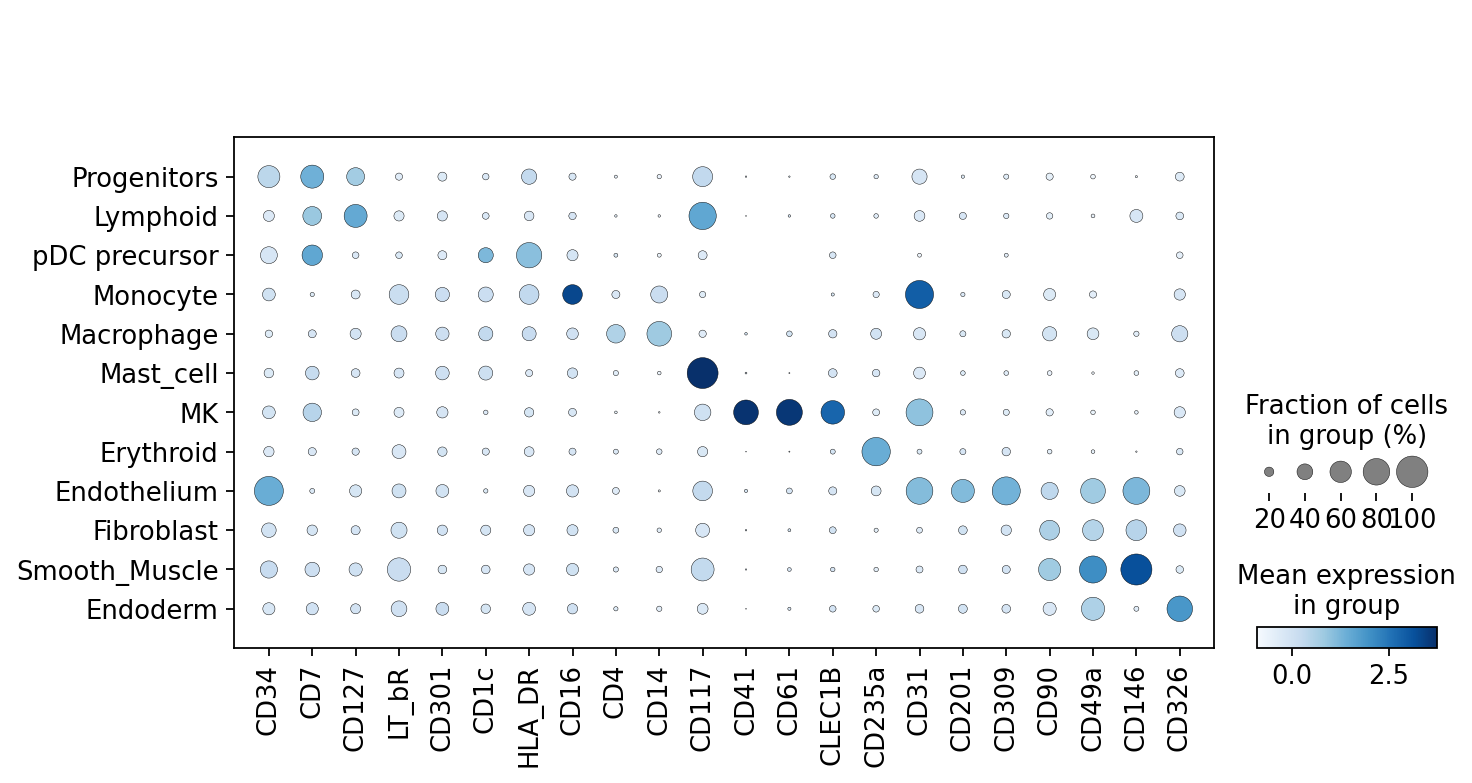

In [290]:
# Plot ran with just GMM regression
sc.pl.dotplot(adata_new, var_names=gene_list1, groupby='final_anno_broad', use_raw=False, cmap='Blues')

# With DSB normalisation and with GMM regression
- this assumes that each batch has similar processing and minimal difference by technical effect thus utilising higher cell numbers to estimate a combined empty drops signature

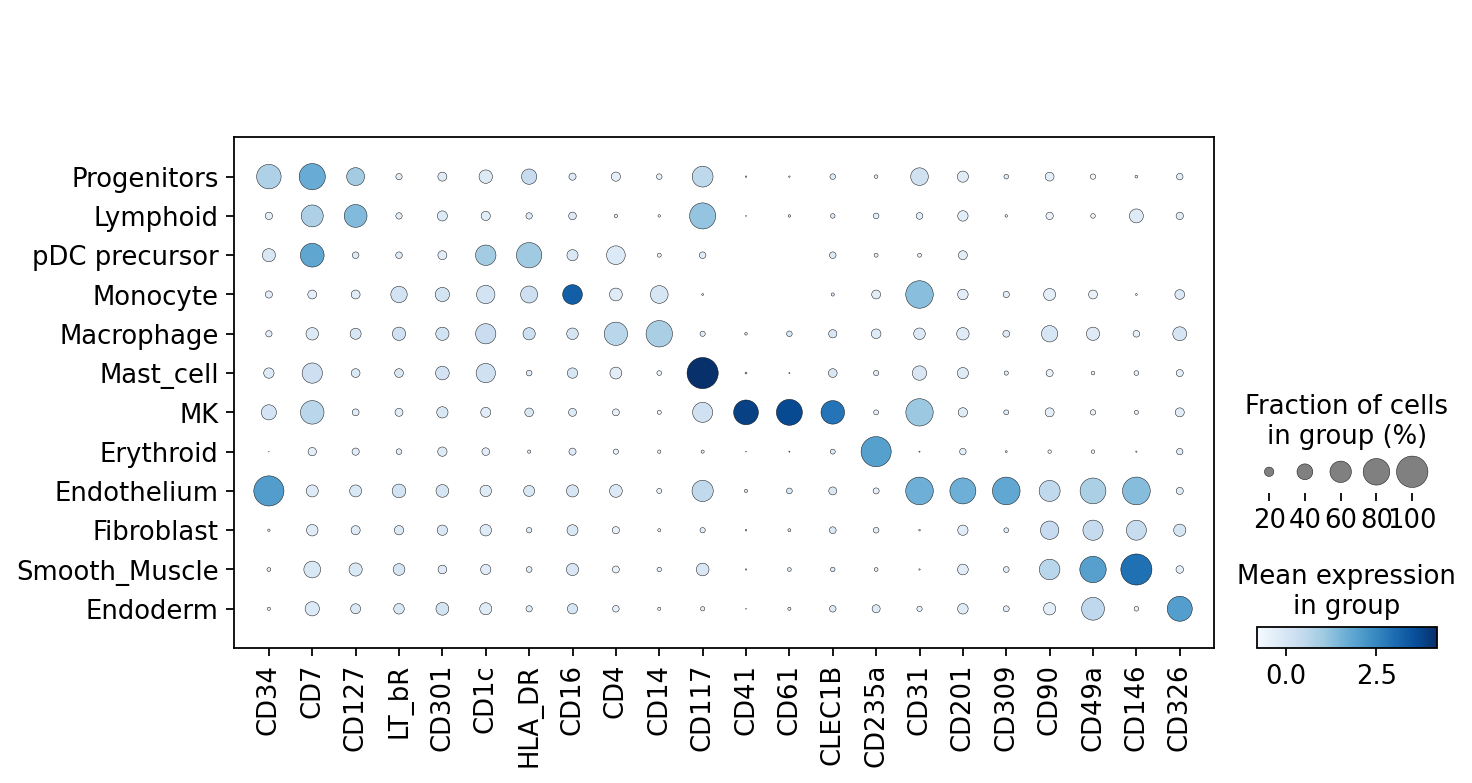

In [464]:
#With DSB normalisation, with regression
sc.pp.scale(adata_new, zero_center=False, max_value=None, copy=False)
sc.pl.dotplot(adata_new, var_names=gene_list1, groupby='final_anno_broad', use_raw=False, cmap='Blues')

# Plot ran with just dsb normalisation 

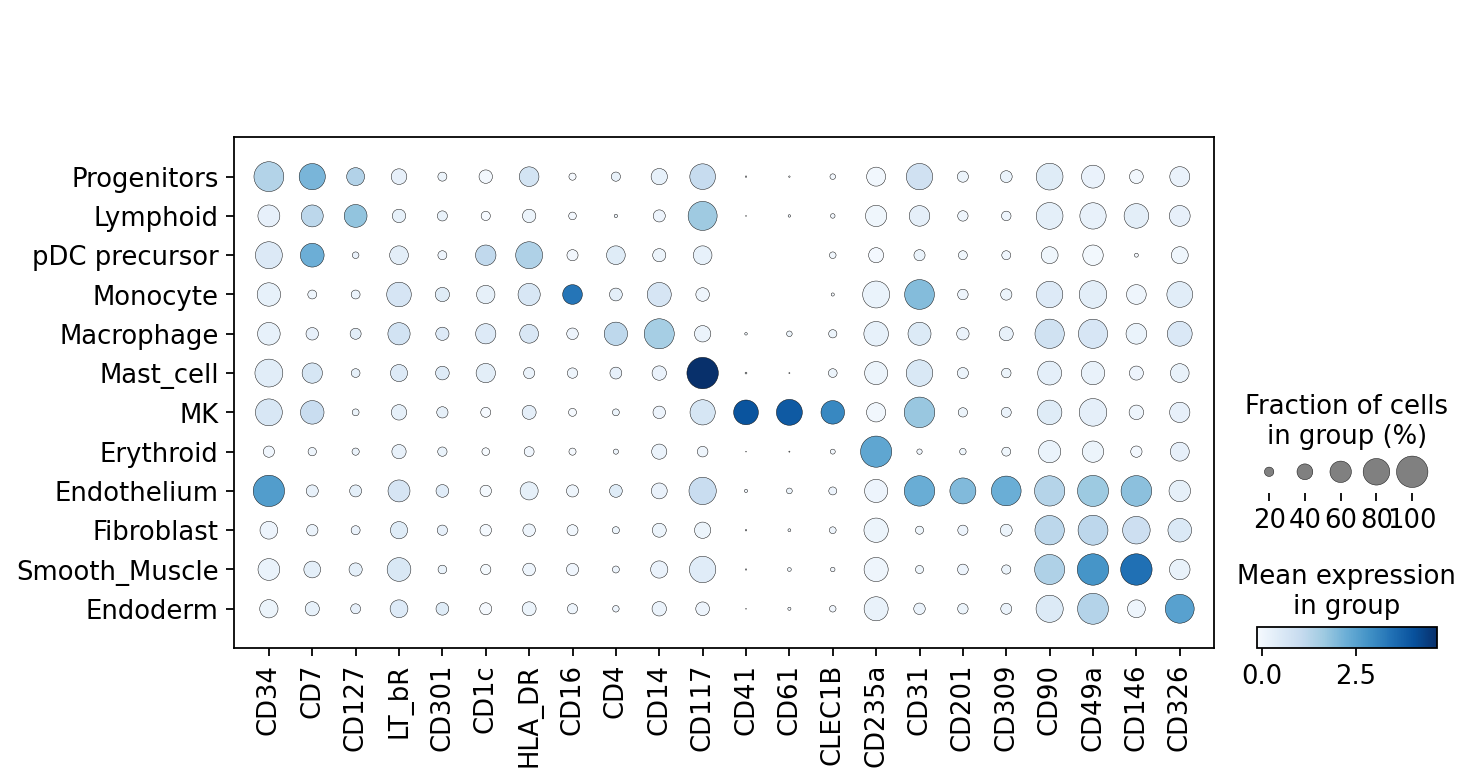

In [312]:
# Plot ran with just dsb normalisation 
sc.pp.scale(adata_new, zero_center=False, max_value=None, copy=False)
sc.pl.dotplot(adata_new, var_names=gene_list1, groupby='final_anno_broad', use_raw=False, cmap='Blues')

# Plot ran with just GMM regression

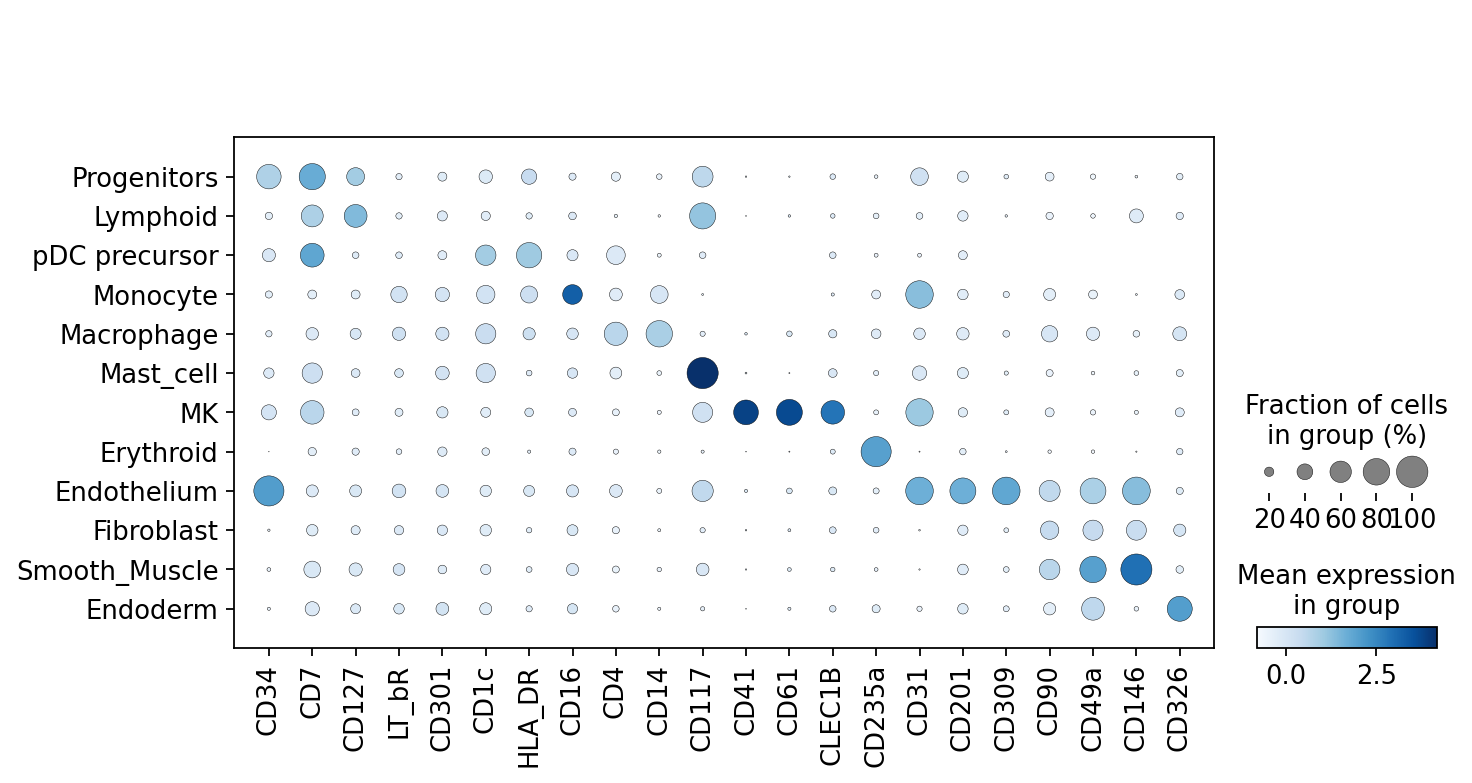

In [475]:
# Plot ran with just GMM regression
sc.pp.scale(adata_new, zero_center=False, max_value=None, copy=False)
sc.pl.dotplot(adata_new, var_names=gene_list1, groupby='final_anno_broad', use_raw=False, cmap='Blues')

# GMM plot example

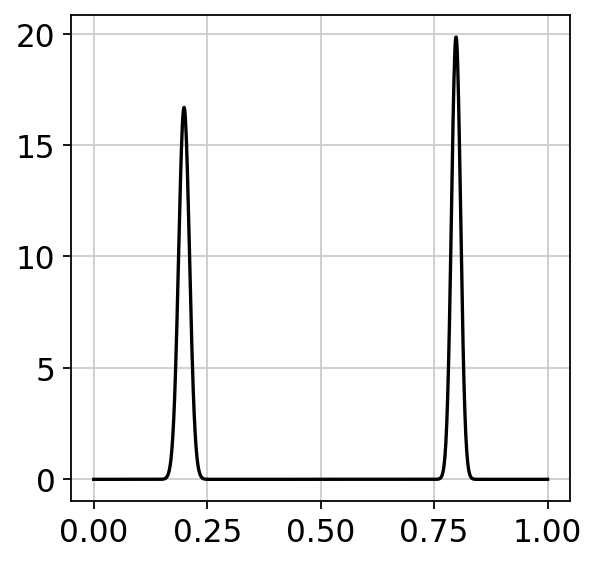

In [75]:
#import numpy as np
#import matplotlib.pyplot as plt
#from sklearn.mixture import GaussianMixture
#np.random.seed(1)
#fig = plt.figure()
#ax = fig.add_subplot(111)
#logprob = gmm_fitted.score_samples(column.reshape(-1,1))
#pdf = np.exp(logprob)
#print np.max(pdf) -> 19.8409464401 !?
#ax.plot(column, pdf, '-k')
#plt.show()

In [478]:
DSB_output0 = adata_new.copy()

In [479]:
save_step = DSB_output0.copy()

In [480]:
sc.tl.pca(DSB_output0, svd_solver='arpack')

computing PCA
    with n_comps=50
    finished (0:00:00)


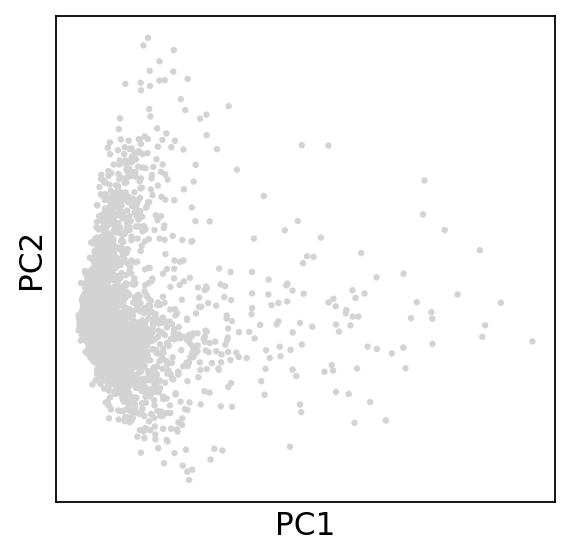

In [485]:
sc.pl.pca(DSB_output0)

# this is showing that expression values are wide range therefore want to scale prior before pca or log 

In [ ]:
# Log the count data 
#sc.pp.log1p(adata)

In [ ]:
# Scale the data
# sc.pp.scale(adata, zero_center=False, max_value=None, copy=False)

In [483]:
# Find variable genes
sc.pp.highly_variable_genes(DSB_output0, min_mean=0.0125, max_mean=3, min_disp=0.5) 

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [484]:
# recalculate pcs
sc.tl.pca(DSB_output0, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=39
    finished (0:00:00)


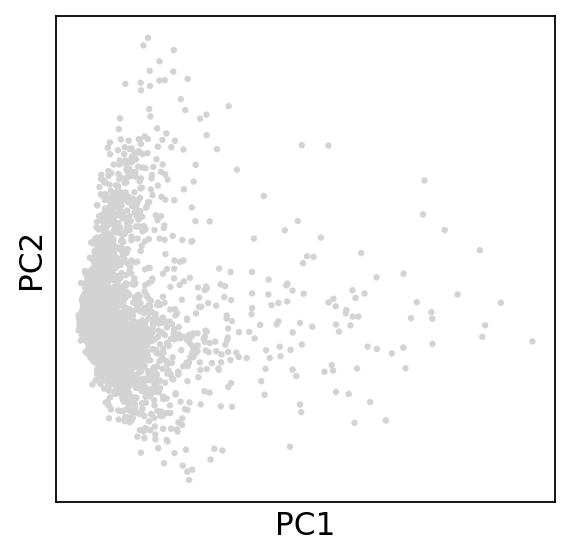

In [486]:
sc.pl.pca(DSB_output0)

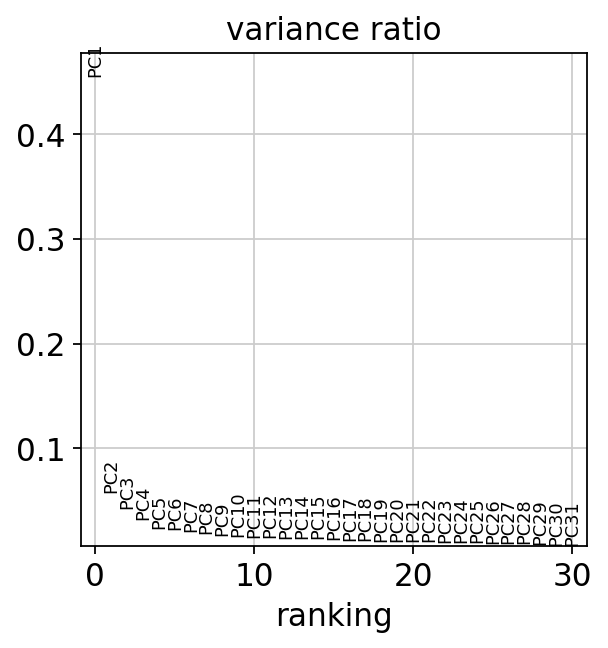

In [487]:
# not logging the data so make sure log=False 
sc.pl.pca_variance_ratio(DSB_output0, log=False)

In [488]:
# This shows have negative values
np.min(DSB_output0.X)
# if need to run degs for proteins in future run line below if hit error # NEVER EVER EVER EVER EVER DO THIS
# DSB_output0.X = np.where(DSB_output0.X < 0, 0, DSB_output0.X)
# INSTEAD SCALE DATA TO REMOVE 0 VALUES

-1.9721941

In [489]:
sc.pp.neighbors(DSB_output0, n_neighbors=10, n_pcs=6)

computing neighbors
    using 'X_pca' with n_pcs = 6
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


In [490]:
sc.tl.umap(DSB_output0)
sc.tl.draw_graph(DSB_output0)
sc.tl.leiden(DSB_output0, resolution=0.5)
#sc.tl.louvain(DSB_output0, resolution=0.5)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:24)
running Leiden clustering
    finished: found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [ ]:
#DSB_output0.write("20210714_mq224_9F_postQC_postDSB_postUmap_CD34_ADT_YS-FL-FBM-CB.h5ad")

In [491]:
DSB_output0

AnnData object with n_obs × n_vars = 3559 × 198
    obs: 'Identifier', 'identifier', 'orig.ident', 'sex', 'final_anno', 'final_anno_broad', 'gmm_score', 'total_counts', 'leiden'
    var: 'bg_mean', 'mean', 'std', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'hvg', 'neighbors', 'umap', 'draw_graph', 'leiden'
    obsm: 'X_pca', 'X_umap', 'X_draw_graph_fa'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [492]:
markers = ['CD19', 'IgG_Fc', 'CD45RA', 'CD81', 'IgM', 'CD10', 'CD22',
       'integrin_b7', 'CD24', 'CD105', 'CD72', 'CD9']

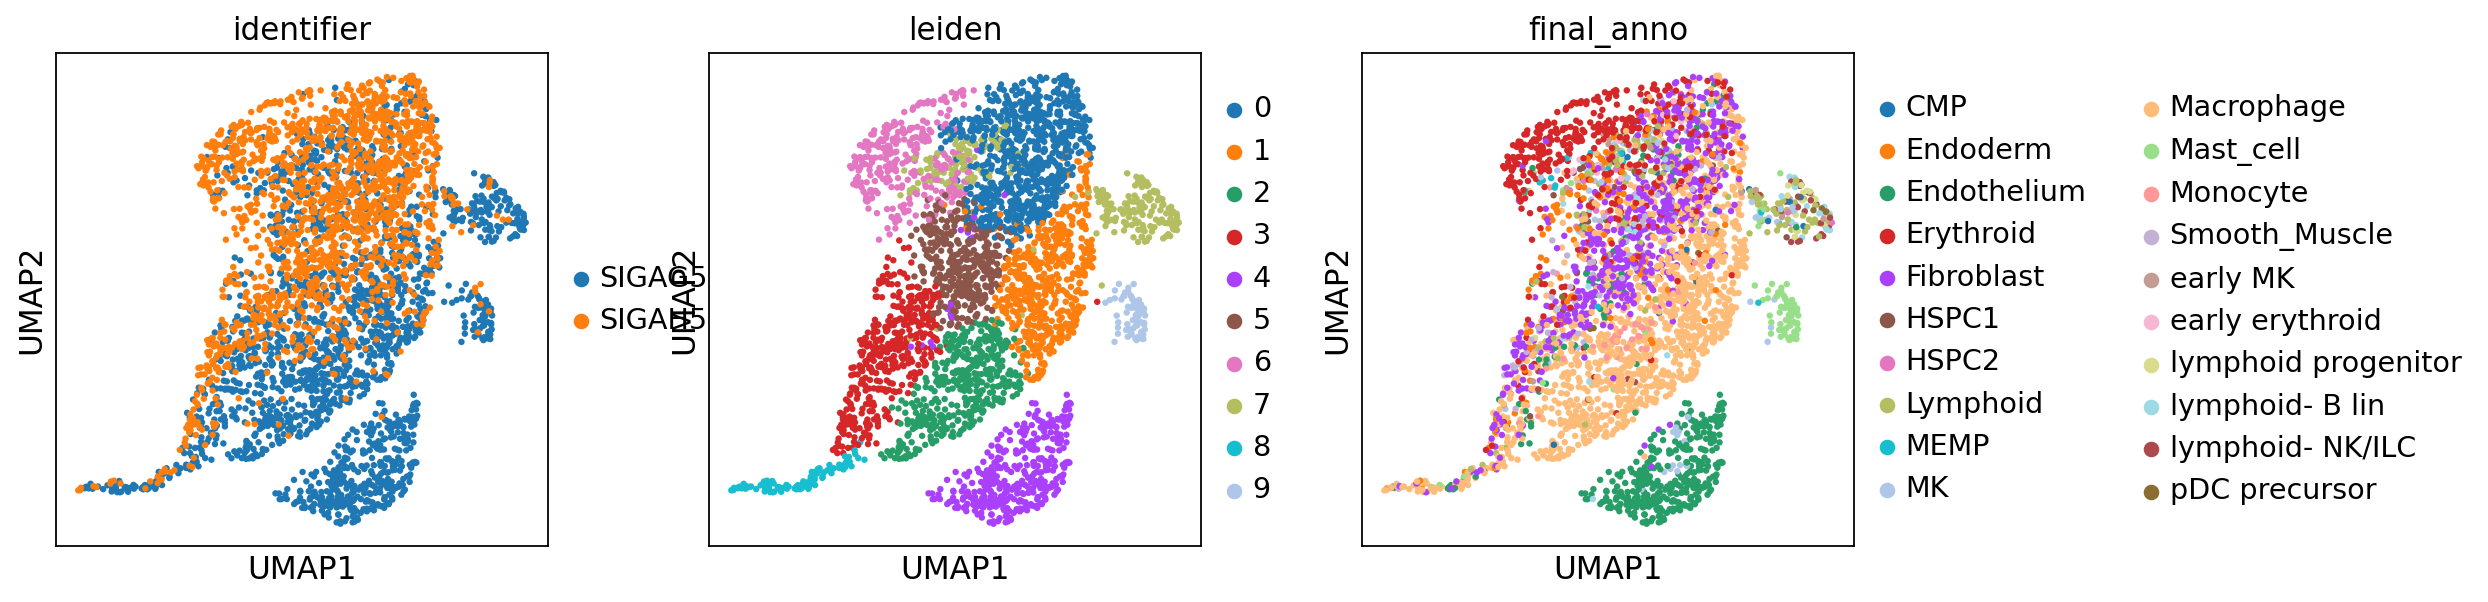

In [501]:
sc.pl.umap(DSB_output0,color=['identifier','leiden','final_anno'])

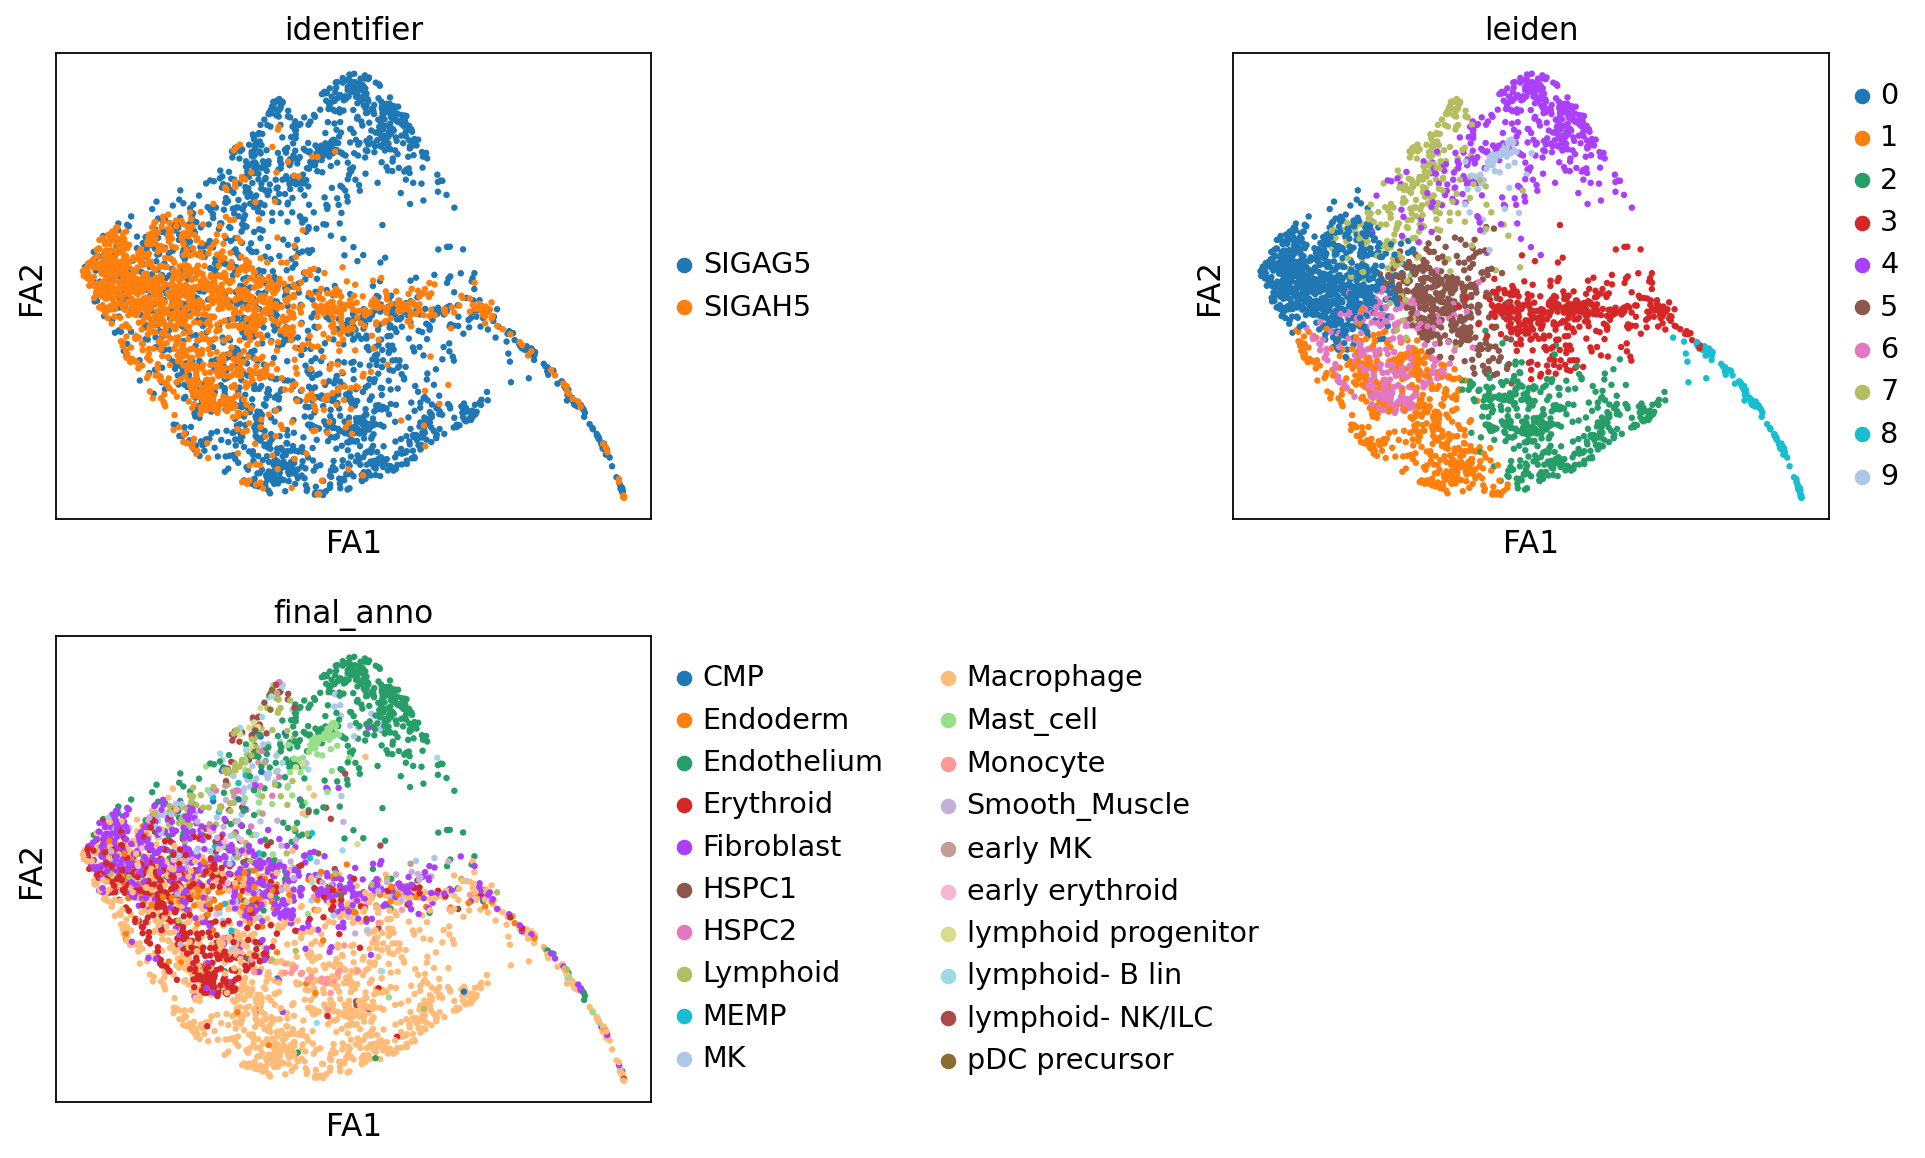

In [502]:
# plot donor for next run
sc.pl.draw_graph(DSB_output0, color=['identifier','leiden','final_anno'], ncols=2, wspace = 0.8)

# Read in mrna co-ordinates example

In [503]:
rna_intersect = rna[rna.obs.index.isin(DSB_output0.obs.index)]

In [504]:
rna_intersect.obs

identifier  orig.ident     sex   final_anno  \
                                                                       
AAACGAAGTTCTTAGG-SIGAE11     SIGAH5    Sample_0  Female   Macrophage   
AAACGCTAGGACTGGT-SIGAE11     SIGAH5    Sample_0  Female    Erythroid   
AAACGCTCATCACAGT-SIGAE11     SIGAH5    Sample_0  Female   Macrophage   
AAACGCTGTATACCCA-SIGAE11     SIGAH5    Sample_0  Female   Macrophage   
AAACGCTTCTAACGCA-SIGAE11     SIGAH5    Sample_0  Female   Fibroblast   
...                             ...         ...     ...          ...   
TTTGTTGCACTGATTG-SIGAD11     SIGAG5    Sample_0  Female   Macrophage   
TTTGTTGCAGCTGTGC-SIGAD11     SIGAG5    Sample_0  Female   Macrophage   
TTTGTTGGTAATGTGA-SIGAD11     SIGAG5    Sample_0  Female  Endothelium   
TTTGTTGGTCAGTCCG-SIGAD11     SIGAG5    Sample_0  Female   Fibroblast   
TTTGTTGGTGGGTTGA-SIGAD11     SIGAG5  Unassigned  Female   Macrophage   

                         final_anno_broad  
                                           
AAACGAAGTTCTTAGG-SIGAE11       Macrophage  
AAACGCTAGGACTGGT-SIGAE11        Erythroid  
AAACGCTCATCACAGT-SIGAE11       Macrophage  
AAACGCTGTATACCCA-SIGAE11       Macrophage  
AAACGCTTCTAACGCA-SIGAE11       Fibroblast  
...                                   ...  
TTTGTTGCACTGATTG-SIGAD11       Macrophage  
TTTGTTGCAGCTGTGC-SIGAD11       Macrophage  
TTTGTTGGTAATGTGA-SIGAD11      Endothelium  
TTTGTTGGTCAGTCCG-SIGAD11       Fibroblast  
TTTGTTGGTGGGTTGA-SIGAD11       Macrophage  

[3559 rows x 5 columns]

In [505]:
DSB_output0.obs[list(rna_intersect.obs.columns)] = rna_intersect.obs[list(rna_intersect.obs.columns)]

In [506]:
DSB_output0.obs

Identifier identifier  orig.ident     sex  \
AGGTTACAGTATGACA-SIGAD11    SIGAD11     SIGAG5    Sample_0  Female   
TACGGTAAGAATAGTC-SIGAD11    SIGAD11     SIGAG5    Sample_0  Female   
AGACACTAGAGGGTAA-SIGAD11    SIGAD11     SIGAG5    Sample_0  Female   
CTAACTTCAATAGGGC-SIGAD11    SIGAD11     SIGAG5    Sample_0  Female   
GTTACCCGTTCTTGCC-SIGAD11    SIGAD11     SIGAG5    Sample_0  Female   
...                             ...        ...         ...     ...   
TACGTCCCACTCCGAG-SIGAE11    SIGAE11     SIGAH5    Sample_0  Female   
ATGTCTTTCGCCACTT-SIGAE11    SIGAE11     SIGAH5  Unassigned  Female   
GACTTCCAGTATGGCG-SIGAE11    SIGAE11     SIGAH5    Sample_1  Female   
TCAGCCTTCTCGCTCA-SIGAE11    SIGAE11     SIGAH5    Sample_0  Female   
AAGACAAAGAACTCCT-SIGAE11    SIGAE11     SIGAH5    Sample_0  Female   

                           final_anno final_anno_broad  gmm_score  \
AGGTTACAGTATGACA-SIGAD11   Macrophage       Macrophage        0.0   
TACGGTAAGAATAGTC-SIGAD11    Erythroid        Erythroid        0.0   
AGACACTAGAGGGTAA-SIGAD11           MK               MK        0.0   
CTAACTTCAATAGGGC-SIGAD11  Endothelium      Endothelium        0.0   
GTTACCCGTTCTTGCC-SIGAD11  Endothelium      Endothelium        0.0   
...                               ...              ...        ...   
TACGTCCCACTCCGAG-SIGAE11   Fibroblast       Fibroblast        0.0   
ATGTCTTTCGCCACTT-SIGAE11     Endoderm         Endoderm        0.0   
GACTTCCAGTATGGCG-SIGAE11    Erythroid        Erythroid        0.0   
TCAGCCTTCTCGCTCA-SIGAE11     Endoderm         Endoderm        0.0   
AAGACAAAGAACTCCT-SIGAE11   Macrophage       Macrophage        0.0   

                          total_counts leiden  
AGGTTACAGTATGACA-SIGAD11  3.467390e+06      0  
TACGGTAAGAATAGTC-SIGAD11  1.930731e+07      6  
AGACACTAGAGGGTAA-SIGAD11  5.595074e+07      4  
CTAACTTCAATAGGGC-SIGAD11  2.589381e+07      4  
GTTACCCGTTCTTGCC-SIGAD11  3.367832e+07      4  
...                                ...    ...  
TACGTCCCACTCCGAG-SIGAE11  1.676065e+06      0  
ATGTCTTTCGCCACTT-SIGAE11  2.095836e+07      2  
GACTTCCAGTATGGCG-SIGAE11  2.480464e+07      3  
TCAGCCTTCTCGCTCA-SIGAE11  3.356752e+06      5  
AAGACAAAGAACTCCT-SIGAE11  3.317413e+07      3  

[3559 rows x 9 columns]

In [507]:
list(rna_intersect.obs.columns)

['identifier', 'orig.ident', 'sex', 'final_anno', 'final_anno_broad']

In [508]:
umap_coords = pd.DataFrame(rna_intersect.obsm['X_umap'])
umap_coords.columns = ['X_UMAP_1','X_UMAP_2']
rna_intersect.obs[['X_UMAP_1','X_UMAP_2']] = umap_coords.values
DSB_output0.obs[list(rna_intersect.obs.columns)] = rna_intersect.obs[list(rna_intersect.obs.columns)]
DSB_output0.obsm['X_umap_back'] = DSB_output0.obsm['X_umap'][:]
DSB_output0.obsm['X_umap'] = DSB_output0.obs[['X_UMAP_1','X_UMAP_2']].values

Trying to set attribute `.obs` of view, copying.


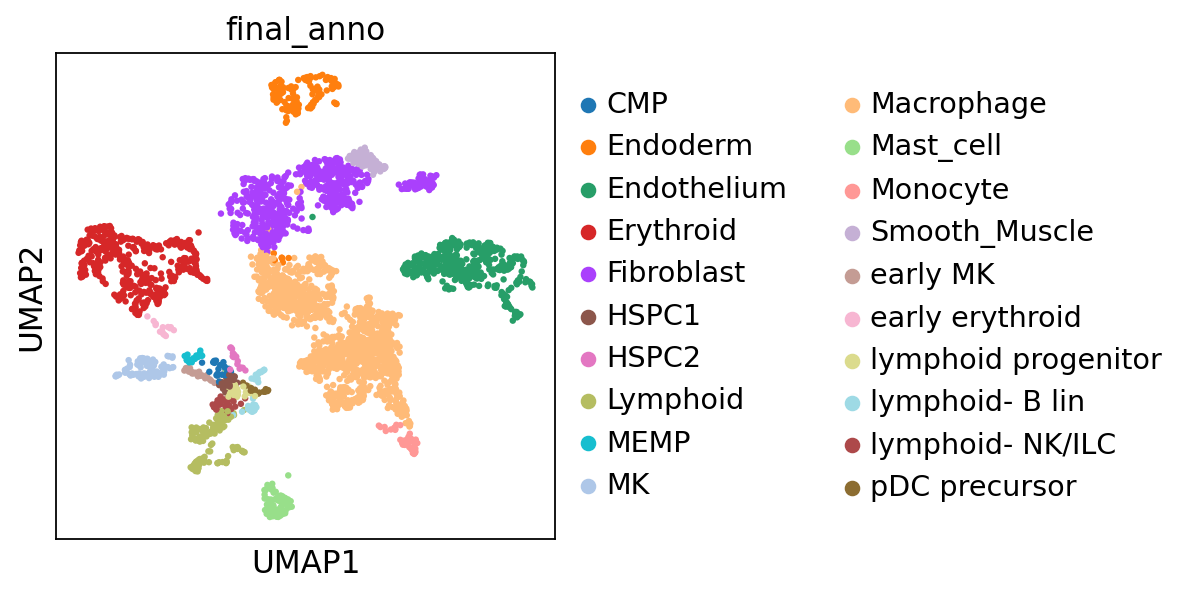

In [510]:
sc.pl.umap(DSB_output0, color= 'final_anno')